### DSP and FFT Validation
This Jupyter Notebook is intended to help verify and compare the results of the ARM CMSIS DSP library when calculating an FFT on a known input dataset. I use Python to generate the C array for the Hanning window (to make the ends of the input data seem continuous for the FFT). Then, I generate a scaled sinusoid with various known frequency components. This data will be copied into the C test function `test_dsp_fft_mag()` and will be scaled properly to a `uint16_t` datatype for testing. Finally, I will print the results of the `dsp_fft_mag()` C function and import them into Python to compare the magnitudes/locations of the peaks in the power spectrum. Note that my implementation in C of the the ARM CMSIS library will use the fixed-point Q1.15 datatype `q15_t`. For my project, I am not necessarily concerned about the size of the resultant FFT magnitude buffer since I am only trying to extract relative sizes and the proper frequency bin to change the LEDs. Therefore, the analysis in this notebook uses various scaling factors to make and show the comparison between the two. 

In [1]:
# use below libraries:
import math 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from numpy import genfromtxt

# constants, defined consistently with the C program:
# the C code will use Q1.15 datatype - 1 sign bit and 15 fractional bits
N = 256
fs = 48000

#### Hanning Window:
Numpy is used to generate the hanning window (will be scaled later when output to C array).

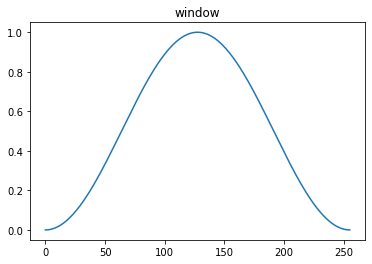

In [2]:
# Generate the Hanning window:
window = np.hanning(N)
idx = np.linspace(0, N-1, N)
plt.plot(idx, window)
plt.title("window")
plt.show()

#### The Input Sinusoid for C Testing
The below code simply generates a waveform with several known frequency components which we will export to C and use to test the `dsp_fft_mag()` function (in C). You can see that we generate a scaled sine wave in the range \[-32768, 32767\] (as if we were sampling 256 points at 48,000 Hz). In the following plot, I depict the samples and an example of what the samples would look like after applying the Hanning window generated previously. 

max: 31454.82662830201, min: -31297.11544583016


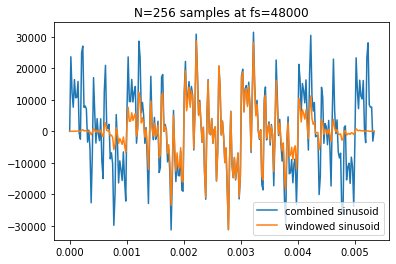

In [3]:
# generate the samples input for C test
freqs = [1000, 2000, 5000, 10000, 15000]
t = np.linspace(0, N/fs, N)
y = np.zeros(len(t))

# sum the sinusoidal components at those freqs
for i in range(len(freqs)):
    y = y+np.sin(2*math.pi*freqs[i]*t)

# extract normalization factor for scaling to int16_t
nrmlz = round(max(abs(min(y)), abs(max(y))))
y = (y*2**15/nrmlz)
print("max: ", max(y), ", min: ", min(y), sep="")

# plot the waveform
plt.plot(t, y, label="combined sinusoid")
plt.plot(t, y*window, label="windowed sinusoid")
plt.title("N={} samples at fs={}".format(len(t),fs))
plt.legend()
plt.show()

#### Running the  FFT in Python
The below code runs the real FFT in Python on the windowed sinusoid shown above. Then, we calculate the magnitude of the FFT result, and find the peaks and their indices (frequencies) in the power spectrum. You can see that Python has no trouble with the recovering the frequencies that we used when generating the input data.

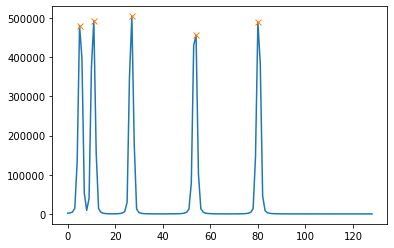

idx |  freq (approx) 
----------------------
  5 |        937
 11 |       2062
 27 |       5062
 54 |      10125
 80 |      15000


In [7]:
# do an fft to extract frequency content:
cmplx = np.fft.rfft(window*y)
# extract magnitude of complex fft output
mag = np.abs(cmplx)
# define the frequency axis
freq_axis = np.fft.rfftfreq(y.size, d=1./fs)
# find peaks:
peak_idx, _ = find_peaks(mag, height=100000)
plt.plot(mag)
plt.plot(peak_idx, mag[peak_idx], "x")
plt.show()

# print indices of peaks:
print("idx |  freq (approx) ")
print("----------------------")
for i in range(len(peak_idx)):
    print("{:>3} | {:>10}".format(peak_idx[i], int(freq_axis[peak_idx[i]])) )

# print full output:
#print("\n\nidx |   freq     | mag  ")
#print("-------------------------")
#for i in range(len(mag)):
#    print("{:>3} | {:>10} | {:>10}".format(i, int(freq_axis[i]), int(mag[i])))

#### Outputs for C Program
Below, we print the output arrays for the Hanning window and the test data for copypasta into C.

In [8]:
# print window to C array
# shift upward to put in uint16_t range
y = np.round(y-min(y))
print("static const int16_t window[NSAMPLES] = {")
for i in range(len(window)):
    print("{:>5}".format(int(window[i]*2**15)), end="")
    if (i!=len(window)-1):
        print(", ", end="")
    else:
        print("};", end="")
    if (i%8==7):
        print("\n", end="")

# print normalized (uint16_t) samples to C array for test waveform  
print("\n\nuint16_t samples_in[NSAMPLES] = {")
for i in range(len(y)):
    print("{:>6}".format(int(y[i])), end="")
    if (i!=len(window)-1):
        print(", ", end="")
    else:
        print("};", end="")
    if (i%8==7):
        print("")

static const int16_t window[NSAMPLES] = {
    0,     4,    19,    44,    79,   124,   178,   243, 
  317,   401,   494,   598,   710,   833,   965,  1106, 
 1256,  1416,  1585,  1762,  1949,  2144,  2348,  2561, 
 2782,  3011,  3248,  3493,  3747,  4007,  4276,  4551, 
 4834,  5124,  5420,  5724,  6034,  6350,  6672,  7000, 
 7334,  7673,  8017,  8367,  8721,  9081,  9444,  9812, 
10184, 10559, 10938, 11321, 11706, 12094, 12485, 12878, 
13274, 13671, 14070, 14470, 14872, 15274, 15677, 16081, 
16484, 16888, 17291, 17694, 18096, 18497, 18897, 19295, 
19691, 20085, 20478, 20867, 21254, 21638, 22019, 22396, 
22770, 23140, 23505, 23867, 24223, 24575, 24923, 25265, 
25601, 25932, 26257, 26576, 26889, 27196, 27496, 27789, 
28075, 28355, 28626, 28891, 29148, 29397, 29638, 29872, 
30097, 30313, 30522, 30721, 30912, 31095, 31268, 31432, 
31587, 31733, 31869, 31997, 32114, 32222, 32321, 32409, 
32489, 32558, 32617, 32667, 32707, 32736, 32756, 32766, 
32766, 32756, 32736, 32707, 32667, 32617, 3255

#### Importing Data from C for Validation and Comparison
The below code imports the FFT magnitude output data captured via minicom over UART for plotting and comparison. Overall there is strong agreement between the C implementation and the (scaled down) Python calculation. In the plot, you can see that the magnitude data output from C shows peaks that are the same indices (frequencies) as those found by Python. 

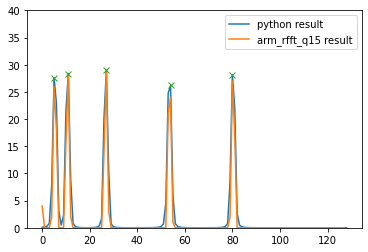

In [35]:
f = open("minicom.cap")
lines = f.readlines()
idx_c = np.zeros(len(lines)-1)
mag_c = np.zeros(len(lines)-1)
freq_c = np.zeros(len(lines)-1)
for i,line in enumerate(lines[:-1]):
    if i==0: 
        continue
    idx_c[i-1],mag_c[i-1],freq_c[i-1] = line.strip("\r\n").split(",")

sf = max(mag)/max(mag_c)
plt.plot(mag/sf, label="python result")
plt.plot(mag_c, label="arm_rfft_q15 result")
plt.plot(peak_idx, mag[peak_idx]/sf, "x")
plt.ylim(top=40,bottom=0)
plt.legend(loc='upper right')
plt.show()

#### Validation of `dsp_find_peaks()` C Function
The following code is used to verify that the C implementation matches the Python implementation of the same algorithm. The idea of the `dsp_find_peaks()` function is that the x-axis of the power spectrum gets chopped up linearly into 8 buckets with 16 discrete FFT frequencies (or sometimes referred to as bins) per bucket (since x-axis has 128 "bins"). For each bucket, we find the index and magnitude associated with the maximal peak in the bucket. It is essentially a linear search for the maximum within each bucket. The results from Python are copied into C for testing and validating correct behavior.

In [37]:
'''
translation of following C algorithm in Python

// algorithm only works for stride = 128/8 = 16 
  int stride = 16;
  int16_t peak = 0;
  int peak_idx = 0;

  for (int i=0; i<FFT_MAG_LEN; i+=stride) {
    peak = fft_mag[i];
    for (int j=0; j<stride; j++) {
      if (peak <= fft_mag[i+j]) {
        peak = fft_mag[i+j];
        peak_idx = i+j;
      }
    }
    dest->mags[i>>4] = peak;
    dest->indices[i>>4] = peak_idx;
'''

peak = np.zeros(8)
bins = np.zeros(8)
i = 0
tmp_peak = 0
tmp_peak_idx = 0

while i<128:
    tmp_peak = mag_c[i]
    for j in range(16):
        if tmp_peak <= mag_c[i+j]:
            tmp_peak = mag_c[i+j]
            tmp_peak_idx = i+j
    
    peak[i>>4] = tmp_peak
    bins[i>>4] = tmp_peak_idx
    i+=16

print("Peak Indices:    ", end="")
for i in range(len(bins)):
    print("{:>4d},".format(int(bins[i])),end="")
print("\nPeak Magnitudes: ",end="")
for i in range(len(peak)):
    print("{:>4d},".format(int(peak[i])),end="")

Peak Indices:      11,  27,  47,  54,  79,  80, 111, 127,
Peak Magnitudes:   28,  29,   0,  24,   2,  27,   0,   0,